In [24]:
import numpy as np
import numpy.typing as npt
import scipy
import scipy.signal as sig
import scipy.io.wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd
from typing import Tuple, List

from numpy.random import default_rng
rng = default_rng()

## 1. TFCT


### 1.1 Généralités


#### a) 

$$
\begin{aligned}
\tilde{X_0}(b, f_0) &= \sum_{n \in \Z} x(n)w(n - b)e^{-2j\pi f_0 n}
\\
&= \left (y_{f_0} * w_- \right)(b)
\\
\end{aligned}
$$
Où :
$$
\begin{aligned}
y_{f_0}(n) &= x(n)e^{-2j\pi f_0 n}
\\
w_-(n) &= w(-n)
\end{aligned}
$$
La fenêtre va opérer un filtrage passe-bas dont la fréquence de coupure
est dictée par sa longueur.

#### b)

On peut écrire :
$$
\begin{aligned}
\tilde{X_{loc}}(b, f_0) &= \sum_{n \in \Z} x(n + b)w(n)e^{-2j\pi f_0 n}
\\
&= \sum_{n \in \Z} x(n)w(n - b)e^{-2j\pi f_0 (n - b)}
\\ 
&= \left ( x * h_{f_0} \right)(b)
\\
&= e^{2j\pi f_0 b} \tilde{X_0}(b, f_0)
\end{aligned}
$$
Où :
$$
\begin{aligned}
h_{f_0}(n) &= w(-n) e^{-2j\pi f_0 n}
\end{aligned}
$$

La fenêtre va opérer un filtrage passe-bande centré sur $f_0$.
La convention utilisée dans `tftc.m` est la convention passe-bande, 
car on écrit la TFTC du signal en $b$ en utilisant seulement les 
échantillons précédents de $x$.

#### c)

In [2]:

audio_dir = "../donnees"
audio_name = 'salsa.wav' 

audio_file = os.path.join(audio_dir, audio_name)
sr, s = wav.read(audio_file)
if s.ndim == 2:
    s = s[:, 0]

ipd.Audio(s, rate=sr)

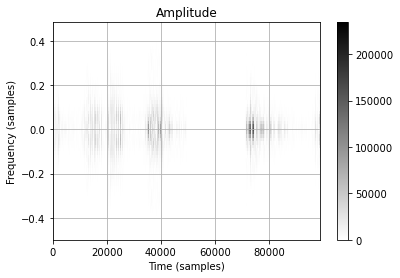

In [3]:
def stft(x: np.ndarray, w: np.ndarray, n_fft: int, step: int) -> np.ndarray:
    m = w.shape[0]
    assert(m <= n_fft)
    nb_frames = (x.shape[0] - m) // step
    #
    x_loc  = np.empty((nb_frames, n_fft), dtype=np.complex128)
    for p in np.arange(nb_frames):
        frame_start = p * step
        frame_stop = frame_start + m
        x_w = x[frame_start:frame_stop] * w
        x_loc[p] = np.fft.fft(x_w, n=n_fft)
    return x_loc

def stft_timefreq(x: np.ndarray, w: np.ndarray, n_fft: int, step: int) -> Tuple[np.ndarray, np.ndarray]:
    m = w.shape[0]
    assert(m <= n_fft)
    nb_frames = (x.shape[0] - m) // step
    #
    times = np.arange(nb_frames)*step
    freqs = np.fft.fftfreq(n=n_fft)
    return times, freqs


def plot_stft(x_loc: np.ndarray, times: np.ndarray, freqs: np.ndarray) -> None:
    f = np.fft.fftshift(freqs)
    x_ft_plot = np.fft.fftshift(x_loc).T
    plt.figure()
    plt.title('Amplitude')
    plt.imshow(np.abs(x_ft_plot), origin='lower', aspect='auto', 
        extent=[times[0], times[-1], f[0], f[-1]],
        interpolation='nearest')
    plt.colorbar()
    plt.set_cmap('gray_r')
    plt.xlabel('Time (samples)')
    plt.ylabel('Frequency (samples)')
    plt.grid(True)

n_fft = 64
m = 32
step = 1

t_start = 1000
t_stop = 100000

w = sig.windows.blackman(m)
x = s[t_start:t_stop]
x_loc = stft(x, w, n_fft, step)
times, freqs = stft_timefreq(x, w, n_fft, step)
plot_stft(x_loc, times, freqs)

k = 3
ipd.Audio(np.real(x_loc[:, k]), rate=sr)

$x_k(p)$ est complexe. Pour $f_k$ fixé, on peut exprimer la 
TFCT de $x$

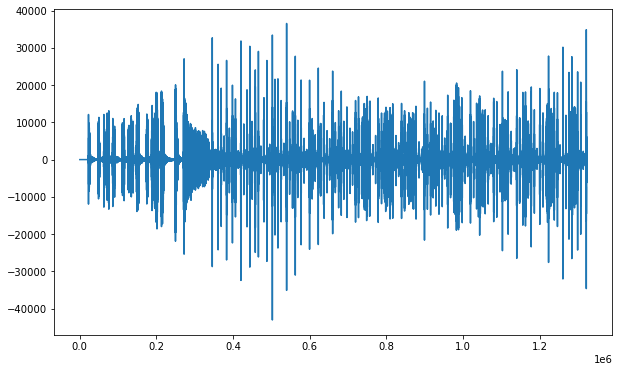

In [4]:
def stft_filter(x: np.ndarray, w: np.ndarray, n_fft: int, step: int, k: int) -> np.ndarray:
    m = w.shape[0]
    assert(m <= n_fft)
    assert(k < n_fft)
    #
    h_k = w[::step] * np.exp(- 2j * np.pi * k / n_fft * np.arange(w.shape[0]))
    x_loc_k = np.convolve(x, h_k, mode='same')
    #
    return x_loc_k

n_fft = 64
m = 32

step = 1
k = 12

t_start = 1000
t_stop = 100000

w = sig.windows.blackman(m)
x_loc_k = stft_filter(s, w, n_fft, step, k)

plt.figure(figsize=(10, 6))
plt.plot(np.real(x_loc_k))

ipd.Audio(np.real(x_loc_k), rate=sr)

À l'écoute de $Re(x_k)$, on entend bien le résultat d'un filtrage passe-bande.


### 1.2 Reconstruction

#### d)

$$
    y(n) = \sum_{m \in \Z} x(m) \left (\sum_{p \in \Z} w(m-pR)w_s(n-pR) \right ) \frac{1}{N}\sum_{k=0}^{N-1} \left ( e^{-2j\pi \frac{m - n}{N}}  \right )^{k}
$$
or :
$$
    \frac{1}{N} \sum_{k=0}^{N-1} \left ( e^{-2j\pi \frac{m - n}{N}}  \right )^{k} = \delta_{m,n}
$$
d'où :
$$
\begin{aligned}
    y(n) &= x(n) \sum_{p \in \Z} w(n-pR)w_s(n-pR)
   \\ 
    &= x(n) \chi(n)
\end{aligned}
$$

#### e)

In [5]:
def overlap(w: npt.NDArray[float], w_s: npt.NDArray[float], nb_frames: int, step: int) -> npt.NDArray[float]:
    m = w.shape[0]
    assert m == w_s.shape[0]
    n_t = m + (nb_frames - 1) * step
    chi = np.zeros(n_t)
    for p in np.arange(nb_frames):
        frame_start = p * step
        frame_stop = frame_start + m
        chi[frame_start:frame_stop] += w * w_s
    return chi

def ola(x_loc: npt.NDArray[np.complex128], w: npt.NDArray[float], w_s: npt.NDArray[float], step: int) -> npt.NDArray[np.complex128]:
    n_fft = x_loc.shape[1]
    m = w.shape[0]
    assert m == w_s.shape[0]
    nb_frames = x_loc.shape[0]
    n_t = m + (nb_frames - 1) * step
    y_s = np.fft.ifft(x_loc, n=n_fft,axis=-1)[..., :m] * w_s
    y = np.zeros(n_t, dtype=np.complex128)
    for p in np.arange(nb_frames):
        frame_start = p * step
        frame_stop = frame_start + m
        y[frame_start:frame_stop] += y_s[p]
    chi = overlap(w, w_s, nb_frames, step)
    x_hat = y / chi
    return x_hat


n_fft = 1024
m = 512

t_start = 1000
t_stop = 100000
x = s[t_start:t_stop]

# On doit centrer les fenêtres sur 0 pour assurer le recouvrement
# Du début du premier et la fin du dernier blocs.
step = m // 4 
w = np.fft.ifftshift(sig.windows.hann(m, sym=False))
w_s = np.fft.ifftshift(sig.windows.hann(m, sym=False))


x_loc = stft(x, w, n_fft, step)
# Vérifions la condition de recouvrement non nul (NOLA) :
chi = overlap(w, w_s, x_hat.shape[0], step)
assert np.all(chi) > 10e-5, "NOLA condition not met!"
#
x_hat = ola(x_loc, w, w_s, step)
print(x.shape, x_hat.shape)
x_diff = x[:x_hat.shape[0]] - x_hat
err_x = np.linalg.norm(x_diff)
print(f"Erreur moyenne: {err_x/len(x_diff)}")

ipd.Audio(np.real(x_hat), rate=sr)

NameError: name 'x_hat' is not defined

#### f)

La condition nécessaire sur le pas $R$ pour assurer le non-repliement du spectre est :
$$
R \leq \frac{M}{2 C_w}
$$
où $M$ est la longueur des fenêtres d'analyse et de synthèse, 
et $C_w$ une largeur de bande normalisée dépendant de la fenêtre.
Pour la fenêtre de Blackman-Harris, on a $C_{w_{BH}} \approx 2$.

Pour un recouvrement minimal, on doit avoir $R$ maximal soit :
$$
R = \frac{M}{2 C_{w_{BH}}} = \frac{M}{4}
$$
c'est-à-dire un recouvrement de 75%.

In [ ]:
# On doit centrer les fenêtres sur 0 pour assurer le recouvrement
# Du début du premier et la fin du dernier blocs.
step = m // 4 
w = np.fft.ifftshift(sig.windows.blackmanharris(m, sym=False))
w_s = np.fft.ifftshift(sig.windows.blackmanharris(m, sym=False))


x_loc = stft(x, w, n_fft, step)
# Vérifions la condition de recouvrement non nul (NOLA) :
chi = overlap(w, w_s, x_hat.shape[0], step)
assert np.all(chi) > 10e-5, "NOLA condition not met!"
#
x_hat = ola(x_loc, w, w_s, step)
print(x.shape, x_hat.shape)
x_diff = x[:x_hat.shape[0]] - x_hat
err_x = np.linalg.norm(x_diff)
print(f"Erreur moyenne: {np.mean(err_x)}")

snr_db_x = 20 * np.log(np.where(np.abs(x[:x_hat.shape[0]]/x_diff)))
print(f"Erreur (S/B): {np.mean(snr_db_x)}")

ipd.Audio(np.real(x_hat), rate=sr)

(99000,) (98816,)
Erreur moyenne: 1.474433890997864e-10
Erreur (S/B): 210.42744465960374


### 1.3 Égaliseur à TFCT

#### g)

In [ ]:
n_fft = 4 # canaux d'égalisation
m = n_fft # on peut pas faire plus que l'échantillonnage en fréquence..

t_start = 1000
t_stop = 100000
x = s[t_start:t_stop]

step = m // 4 
w = np.fft.ifftshift(sig.windows.hann(m, sym=False))
w_s = np.fft.ifftshift(sig.windows.hann(m, sym=False))

x_loc = stft(x, w, n_fft, step)
# Vérifions la condition de recouvrement non nul (NOLA) :
chi = overlap(w, w_s, x_hat.shape[0], step)
assert np.all(chi) > 10e-5, "NOLA condition not met!"
#
# Égalisation aléatoire
gamma = rng.random(n_fft)
# Égalisation arbitraire
# gamma = np.array([0.91, 0.1, 0.01, 0.])
# Pas d'égalisation
# gamma = np.ones(n_fft)
#
x_loc *= gamma
#
x_hat = ola(x_loc, w, w_s, step)
print(x.shape, x_hat.shape)
x_diff = x[:x_hat.shape[0]] - x_hat

snr_db_x = 20 * np.log(np.where(np.abs(x[:x_hat.shape[0]]/x_diff)))
print(f"Erreur (S/B): {np.mean(snr_db_x)}")

ipd.Audio(np.real(x_hat), rate=sr)

(99000,) (98999,)
Erreur (S/B): -inf


/home/xabbu/anaconda3/envs/env_signal/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/xabbu/anaconda3/envs/env_signal/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


## 2. Modifications

### 2.1 Étirement temporel

#### a)

On a entre deux instants $\tau$ et $\tau + 1$ :
$$
\begin{aligned}
\tilde{X_0}(\tau, \nu) &= \sum_{n \in \Z} e^{2j\pi (\nu_0 - \nu)n} w(n - \tau)
\\
\tilde{X_0}(\tau + 1, \nu) &= \sum_{n \in \Z} e^{2j\pi (\nu_0 - \nu)(n + 1)} w(n - \tau)
= e^{2j\pi (\nu_0 - \nu)} \tilde{X_0}(\tau, \nu) 
\end{aligned}
$$
Soit un déphasage de $2\pi (\nu_0 - \nu)$ entre deux périodes d'échantillonnage successives, avec $|\nu_0 - \nu| \leq 1$.

In [6]:
n_fft = 32 
m = n_fft//2

n_t = 10000
f_0 = 440
x = np.exp(2j * np.pi * f_0 / sr * np.arange(n_t))

step = m // 4 
w = np.fft.ifftshift(sig.windows.hann(m, sym=False))
w_s = np.fft.ifftshift(sig.windows.hann(m, sym=False))

x_loc = stft(x, w, n_fft, step)
phi_x_loc = np.apply_along_axis(func1d=np.angle, axis=-1, arr=x_loc)
phi_diff = np.abs(phi_x_loc - np.roll(phi_x_loc, shift=1, axis=-1))
print(f"Déphasage instantané max : {np.max(phi_diff)/np.pi} rad")

Déphasage instantané max : 1.7565033308197637 rad


#### b)
M
$$
\begin{aligned}
\tilde{X_0}(\tau + R, \nu) &= \sum_{n \in \Z} e^{2j\pi (\nu_0 - \nu)(n + R)} w(n - \tau)
= e^{2j\pi (\nu_0 - \nu)R} \tilde{X_0}(\tau, \nu) 
\end{aligned}
$$
soit :
$$
\begin{aligned}
\Delta_{\phi} \leq 2\pi & \iff 2\pi |\Delta_{\nu}| R \leq 2\pi
\\
& \iff R \leq \frac{1}{|\Delta_{\nu}|}
\end{aligned}
$$

#### c)

Lors d'un sous-échantillonnage temporel d'un facteur $R$, 
on perd des fréquences à partir de $\frac{1}{2R}$ en fréquence réduite,
on a donc sous-échantillonnage sans perte d'information si :
$$
\nu_{max} \leq  \frac{1}{2R} \iff R \leq \frac{1}{2\nu_{max}}
$$
Pour avoir reconstruction parfaite et nul dépassement de phase,
on doit finalement avoir :
$$
R \leq \frac{1}{\max(|{\Delta_{\nu}|}, 2\nu_{max})}
$$
__Interprétation__ ?

#### d)

Pour étirer le son, on doit avoir
$R_a > R_s$,
or on a $R_s = \frac{1}{2\nu_{max}}$,
donc $R_a > \frac{1}{2\nu_{max}}$ et
l'on observera du repliement dès l'analyse.

#### e)

On choisira des filtres passe-bas pour éliminer les $\Delta_{\nu}$
qui ne vérifient pas la condition sur $R$ :
$$
\begin{aligned}
|\Delta_{\nu}| & \leq \frac{1}{R}
\\
\end{aligned}
$$
On aura donc un filtrage passe-bas de fréquence de coupure $\frac{1}{R}$.
![schema_phase](../doc/schema_phase.png)
_source : Mark Dolson, 'The Phase Vocoder: a Tutorial'_

In [32]:

def get_lowpass_order(nu_c: float, nu_a: float, delta_1:float, delta_2:float) -> int:
    return min(2, int(np.round((2/3) * (-np.log10(10 * delta_1 * delta_2)) / (nu_a - nu_c))))

def get_lowpass(nu_c: float, nu_a: float, order: int) -> npt.NDArray[float]:
    return sig.remez(order, [0, nu_c, nu_a, 0.5], [1, 0])

def get_lowpass_band(nu_as: npt.NDArray[float]) -> List[List[float]]:
    # valeurs arbitraires
    nu_cs = nu_as * 0.90
    delta_1 = 0.1
    delta_2 = 0.01
    #
    orders = np.array([get_lowpass_order(nu_c, nu_a, delta_1, delta_2) for (nu_c, nu_a) in np.nditer([nu_cs, nu_as])])
    print(orders)
    # 'optimising' list creation
    # see: https://stackoverflow.com/a/22225721
    hs = [get_lowpass(nu_c, nu_a, get_lowpass_order(nu_c, nu_a, delta_1, delta_2)) for (nu_c, nu_a) in np.nditer([nu_cs, nu_as])]
    return hs

def band_estimate_params(x_loc: npt.NDArray[np.complex128], step: int) -> Tuple[npt.NDArray[float], npt.NDArray[float]]:
    nb_frames = x_loc.shape[0]
    n_fft = x_loc.shape[1]
    pp, kk = np.meshgrid(np.arange(nb_frames), np.arange(n_fft))
    z_mod = np.exp(2j*np.pi*kk/n_fft*pp)
    x_loc_pass = x_loc * z_mod.T
    #
    nu_as = np.full(n_fft, fill_value=1/step)
    hs = get_lowpass_band(nu_as)
    for k in np.arange(n_fft):
        x_loc_pass[:, k] = sig.lfilter(hs[k],[1], x_loc_pass[:, k])
    #
    amps = np.abs(x_loc_pass)**2
    freqs = None
    return amps, freqs

n_fft = 16 
m = n_fft//2

t_start = 1000
t_stop = 5000
x = s[t_start:t_stop]

step = m // 4 
w = np.fft.ifftshift(sig.windows.hann(m, sym=False))
w_s = np.fft.ifftshift(sig.windows.hann(m, sym=False))

x_loc = stft(x, w, n_fft, step)

amps, freqs = band_estimate_params(x_loc, step)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
